# Challege: Housing Prices
In this project I will create models to predict housing prices using the [Housing Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) dataset from Kaggle. All models will be created using linear regression. Three regularization techniques, Ridge, Lasso, and Elastic Net, will be considered as I explore which model does the best job at predicting housing prices.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sqlalchemy import create_engine

import helpers as hp
from config import usr, pwd, url, port, db

%matplotlib inline

## Load Data
Load the dataset and inspect it's contents.

In [2]:
engine = create_engine(f"postgresql+psycopg2://{usr}:{pwd}@{url}:{port}/{db}")

In [3]:
query = f'''
SELECT
    *
FROM
    {db};
'''

In [4]:
df = pd.read_sql_query(query, con=engine)

In [5]:
engine.dispose()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

## Data Cleaning 1
### Variable types
Create lists of continuous and categorical variables. I will handle this different types of variables separately during the data cleaning and feature engineering stages.

In [7]:
cont_variables, cat_variables = hp.find_variable_types(df)

In [8]:
print(f'Continuous variables:\n{cont_variables}\n')
print(f'Categorical variables:\n{cat_variables}')

Continuous variables:
['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf', 'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd', 'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf', 'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch', 'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice']

Categorical variables:
['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2', 'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation', 'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual', 'function

Remove `'id'` column from `cont_variables` since this column isn't a variable.

In [9]:
cont_variables.remove('id')

### Year variables
Convert year variables into durations (ages). This way I can treat these features an continous variables.

In [10]:
year_columns = ['garageyrblt', 'yearremodadd', 'yearbuilt', 'yrsold']
age_columns = ['garageage', 'remodage', 'age', 'yrsoffmk']

Before continuing, I will copy the intial `DataFrame` to a new `DataFrame` so that I can preserve the initial, raw dataset.

In [11]:
df_clean = df.copy()

Fill missing values with the current year. When the year built is calculated, it will be zero, consistant with no garage on the property.

In [12]:
df_clean['garageyrblt'].fillna(value=2019, inplace=True)
df_clean = df_clean.astype({'garageyrblt': 'int64'})

In [13]:
for i, year_type in enumerate(year_columns):
    df_clean[age_columns[i]] = 2019 - df_clean[year_type]

In [14]:
df_clean.loc[:, age_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 4 columns):
garageage    1460 non-null int64
remodage     1460 non-null int64
age          1460 non-null int64
yrsoffmk     1460 non-null int64
dtypes: int64(4)
memory usage: 45.7 KB


In [15]:
df_clean.loc[:, age_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
garageage,1460.0,38.247260,25.724002,0.0,16.0,34.5,57.0,119.0
remodage,1460.0,34.134247,20.645407,9.0,15.0,25.0,52.0,69.0
age,1460.0,47.732192,30.202904,9.0,19.0,46.0,65.0,147.0
yrsoffmk,1460.0,11.184247,1.328095,9.0,10.0,11.0,12.0,13.0


Update continuous variables list.

In [16]:
cont_variables = [x for x in cont_variables if x not in year_columns]
cont_variables += age_columns

### Unique categories
Let's see what the categories are for each categorical variable by printing the unique categories for each value.

In [17]:
hp.print_unique_categories(df, cat_variables)

mszoning: ['RL' 'RM' 'C (all)' 'FV' 'RH']
street: ['Pave' 'Grvl']
alley: [None 'Grvl' 'Pave']
lotshape: ['Reg' 'IR1' 'IR2' 'IR3']
landcontour: ['Lvl' 'Bnk' 'Low' 'HLS']
utilities: ['AllPub' 'NoSeWa']
lotconfig: ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
landslope: ['Gtl' 'Mod' 'Sev']
neighborhood: ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
condition1: ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
condition2: ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
bldgtype: ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
housestyle: ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
roofstyle: ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']
roofmatl: ['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran' 'Tar&Grv' 'Roll'
 'ClyTile']
exterior1st: ['V

### Missing Values
I will deal with missing values in the dataset.

#### Missing categories
The missing values in the category columns are labeled as `None`. I will replace these with the string `"None"`. Thus, `"None"` will be an additional category for each categorical variable.

In [18]:
df_clean = hp.fill_missing_categories(df_clean, cat_variables)

#### Missing value fractions
Now let's see which variable are still missing values.

In [19]:
hp.find_na_columns(df_clean, display_fractions=True)

Variables and their fraction of missing values:
lotfrontage    17.739726
masvnrarea      0.547945
dtype: float64


In [20]:
na_fractions = hp.find_na_columns(df_clean)

In [21]:
df_clean.loc[:, na_fractions.index].describe().T

,count,mean,std,min,25%,50%,75%,max
lotfrontage,1201.0,70.049958,24.284752,21.0,59.0,69.0,80.0,313.0
masvnrarea,1452.0,103.685262,181.066207,0.0,0.0,0.0,166.0,1600.0


I will fill the missing values for these variables with zeros.

In [22]:
df_clean['lotfrontage'].fillna(value=0, inplace=True)
df_clean['masvnrarea'].fillna(value=0, inplace=True)

In [23]:
hp.find_na_columns(df_clean, display_fractions=True)

Variables and their fraction of missing values:
Series([], dtype: float64)


All missing values have now been dealt with.

In [24]:
print(f'The dataset size is still {len(df_clean)} rows long.')

The dataset size is still 1460 rows long.


## Feature Selection
Before dealing with outliers and normalizing the data, I will make the dataset smaller by removing some unimportant features. I will only select continous variables that have at least a 0.6 correlation with _salesprice_. I will use $\chi$<sup>2</sup> to select categorical variables that are relavent to predicting _saleprice_.


### Continous Variables
Select variables that are correlated with saleprice.

In [25]:
df_correlated = df_clean.loc[:, cont_variables].corr()
correlated_with_saleprice = df_correlated['saleprice'].sort_values()

In [26]:
correlated_with_saleprice

age             -0.522897
remodage        -0.507101
garageage       -0.353196
kitchenabvgr    -0.135907
enclosedporch   -0.128578
mssubclass      -0.084284
overallcond     -0.077856
lowqualfinsf    -0.025606
miscval         -0.021190
bsmthalfbath    -0.016844
bsmtfinsf2      -0.011378
yrsoffmk         0.028923
threessnporch    0.044584
mosold           0.046432
poolarea         0.092404
screenporch      0.111447
bedroomabvgr     0.168213
lotfrontage      0.209624
bsmtunfsf        0.214479
bsmtfullbath     0.227122
lotarea          0.263843
halfbath         0.284108
openporchsf      0.315856
secondflrsf      0.319334
wooddecksf       0.324413
bsmtfinsf1       0.386420
fireplaces       0.466929
masvnrarea       0.472614
totrmsabvgrd     0.533723
fullbath         0.560664
firstflrsf       0.605852
totalbsmtsf      0.613581
garagearea       0.623431
garagecars       0.640409
grlivarea        0.708624
overallqual      0.790982
saleprice        1.000000
Name: saleprice, dtype: float64

In [27]:
correlated_features = correlated_with_saleprice[correlated_with_saleprice > 0.6].index.tolist()

# Remove the target variable since it is not a feature
correlated_features.remove('saleprice')

In [28]:
print(f'Features that have at least a 0.6 correlations with sale price are:\n{correlated_features}')

Features that have at least a 0.6 correlations with sale price are:
['firstflrsf', 'totalbsmtsf', 'garagearea', 'garagecars', 'grlivarea', 'overallqual']


Create list of continous variables that includes the selected continous variable features as well as `'saleprice_sd'`.

In [29]:
correlated_variables = correlated_features
correlated_variables.append('saleprice')

### Catagorical variables
Use $\chi$<sup>2</sup> technique to remove categorical variables that are not correlated with `'saleprice'`. Only select features with a p-value less than 0.05.

In [30]:
cat_features = hp.select_cat_variables(df_clean, 'saleprice', cat_variables, alpha=0.05)

Feature Chi-squared Statistics: (p-value < 0.05)
* mszoning: chi2 = 3147.891, p-value = 4.348e-11, dof = 2648
* street: chi2 = 888.313, p-value = 8.339e-09, dof = 662
* lotshape: chi2 = 2446.235, p-value = 4.725e-12, dof = 1986
* lotconfig: chi2 = 2771.985, p-value = 4.581e-02, dof = 2648
* neighborhood: chi2 = 16898.756, p-value = 1.365e-08, dof = 15888
* masvnrtype: chi2 = 2293.470, p-value = 1.598e-06, dof = 1986
* exterqual: chi2 = 2849.767, p-value = 4.250e-34, dof = 1986
* extercond: chi2 = 3192.840, p-value = 9.870e-13, dof = 2648
* foundation: chi2 = 3669.192, p-value = 9.665e-06, dof = 3310
* bsmtqual: chi2 = 3552.151, p-value = 1.192e-29, dof = 2648
* bsmtcond: chi2 = 3386.500, p-value = 4.710e-21, dof = 2648
* bsmtexposure: chi2 = 3230.188, p-value = 3.496e-14, dof = 2648
* heating: chi2 = 4201.388, p-value = 2.478e-24, dof = 3310
* centralair: chi2 = 826.857, p-value = 1.226e-05, dof = 662
* kitchenqual: chi2 = 2811.800, p-value = 1.282e-31, dof = 1986
* fireplacequ: chi2 =

Convert categorical features into dummy, one-hot-encoded variables.

In [31]:
df_clean = hp.dummyify(df_clean, cat_features)

## Data Cleaning 2
### Outliers
Inspect continous variables and correct outlier using the Tukey method.

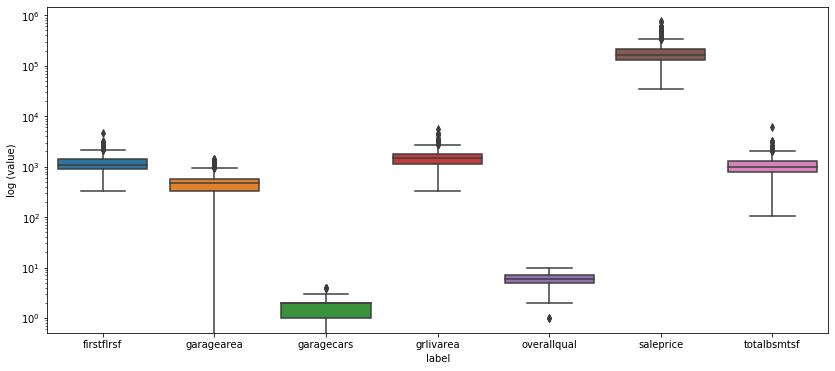

In [32]:
hp.look_for_outliers(df_clean, correlated_variables, log_scale=True)

**Observations:** Several features show outliers. I will correct for these using the Tukey method.

In [33]:
# Correct outliers using Tukey method
hp.thresholds['tukey'] = 2.0
tk_corrected = [f'{x}_tk' for x in correlated_variables]
df_clean = hp.correct_outliers(df_clean, correlated_variables)

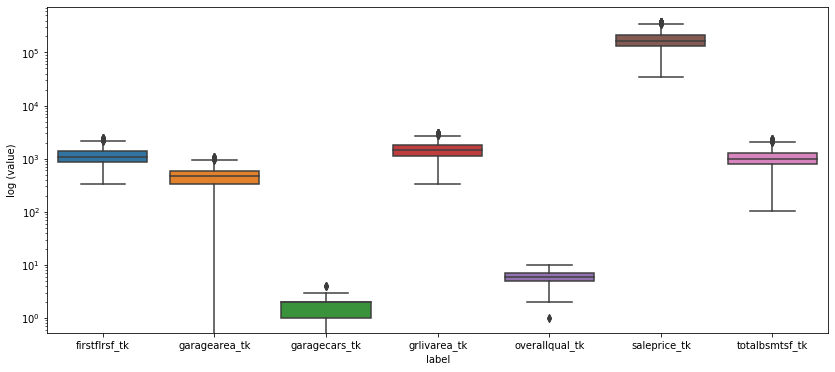

In [34]:
hp.look_for_outliers(df_clean, tk_corrected, log_scale=True)

**Observations:** The number of outliers has been reduced. Now, I will standardize the dataset.

### Standardize
I will standarize all continous variables.

In [35]:
stand_variables = [f'{x}_sd' for x in tk_corrected]
df_clean = hp.standardize(df_clean, tk_corrected)

### Normality
I will check the standardized continous variables for normality. If they aren't normal, I will correct them using using a Box-Cox transformation.

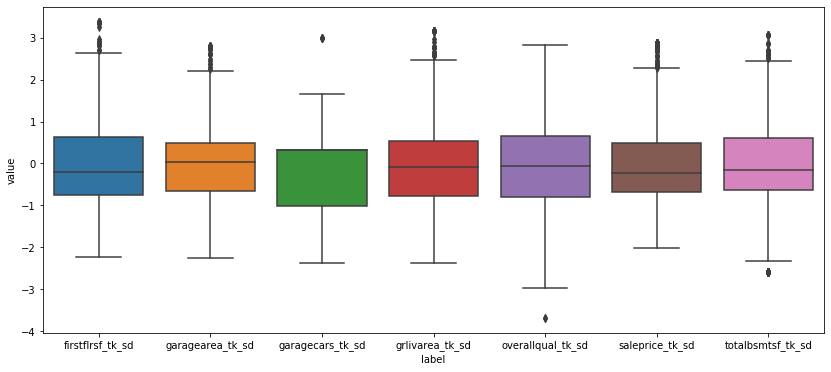

In [36]:
hp.look_for_outliers(df_clean, stand_variables)

In [37]:
hp.check_for_normality(df_clean, stand_variables)

Normal test results:
* firstflrsf_tk_sd: normal_stat = 125.529, p-value = 0.0000.
* totalbsmtsf_tk_sd: normal_stat = 38.780, p-value = 0.0000.
* garagearea_tk_sd: normal_stat = 5.965, p-value = 0.0507.
* garagecars_tk_sd: normal_stat = 29.925, p-value = 0.0000.
* grlivarea_tk_sd: normal_stat = 121.423, p-value = 0.0000.
* overallqual_tk_sd: normal_stat = 11.905, p-value = 0.0026.
* saleprice_tk_sd: normal_stat = 203.174, p-value = 0.0000.


**Observation:** All continous variables except _garagarea_ are not normal. The non-normal variables have very low p-values. I will try transforming the data using a Box-Cox transform and see if that improve things.

In [38]:
bc_variables = [f'{x}_bc' for x in stand_variables]
df_clean = hp.apply_boxcox_transform(df_clean, stand_variables)

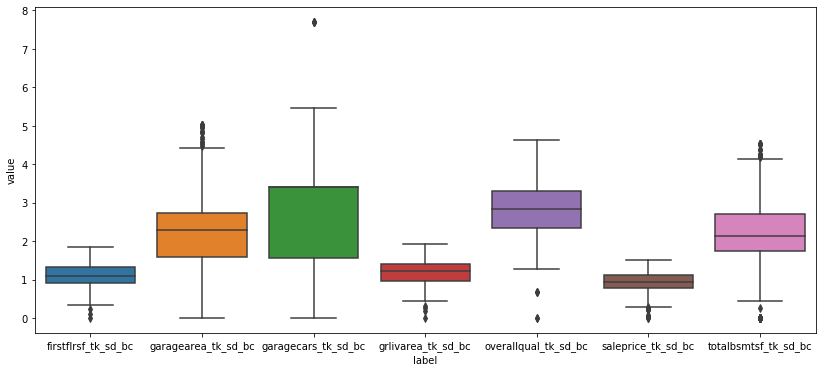

In [39]:
hp.look_for_outliers(df_clean, bc_variables)

In [40]:
hp.check_for_normality(df_clean, bc_variables)

Normal test results:
* firstflrsf_tk_sd_bc: normal_stat = 2.902, p-value = 0.2344.
* totalbsmtsf_tk_sd_bc: normal_stat = 23.056, p-value = 0.0000.
* garagearea_tk_sd_bc: normal_stat = 5.939, p-value = 0.0513.
* garagecars_tk_sd_bc: normal_stat = 1.357, p-value = 0.5073.
* grlivarea_tk_sd_bc: normal_stat = 2.743, p-value = 0.2537.
* overallqual_tk_sd_bc: normal_stat = 3.444, p-value = 0.1787.
* saleprice_tk_sd_bc: normal_stat = 1.403, p-value = 0.4959.


**Observations:** Now, the only feature that is not normal is `'totalbsmtsf_tk_sd_bc'`.

## Data Exploration
Here, I will focus on the correlations between the continous variables and the one-hot-encoded categorical features.
### Correlated continous features
Let's see how these variables are correlated.

In [41]:
cont_corrected_features = ['firstflrsf_tk_sd_bc', 'totalbsmtsf_tk_sd_bc', 'garagearea_tk_sd_bc', 
                           'garagecars_tk_sd_bc', 'grlivarea_tk_sd_bc', 'overallqual_tk_sd_bc']

In [42]:
df_clean.loc[:, cont_corrected_features].corr()

,firstflrsf_tk_sd_bc,totalbsmtsf_tk_sd_bc,garagearea_tk_sd_bc,garagecars_tk_sd_bc,grlivarea_tk_sd_bc,overallqual_tk_sd_bc
firstflrsf_tk_sd_bc,1.000000,0.776878,0.482988,0.457391,0.535647,0.449070
totalbsmtsf_tk_sd_bc,0.776878,1.000000,0.478354,0.459307,0.414689,0.536235
garagearea_tk_sd_bc,0.482988,0.478354,1.000000,0.886557,0.475227,0.562317
garagecars_tk_sd_bc,0.457391,0.459307,0.886557,1.000000,0.502433,0.602338
grlivarea_tk_sd_bc,0.535647,0.414689,0.475227,0.502433,1.000000,0.609463
overallqual_tk_sd_bc,0.449070,0.536235,0.562317,0.602338,0.609463,1.000000


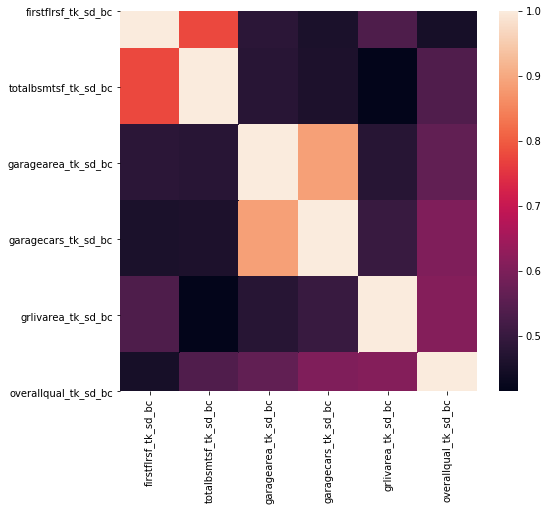

In [43]:
f, axes = plt.subplots(1, 1, figsize=(8, 7))
sns.heatmap(df_clean.loc[:, cont_corrected_features].corr(), ax=axes)
plt.show()

**Observations:** `'garagearea_tk_sd_bc'` and `'garagecars_tk_sd_bc'` have a high correlation. I will address this issue by creating a new variable, `'garage_car_area'`, by multiplying these two variables together.

In [44]:
df_clean['garage_car_area'] = df_clean['garagearea_tk_sd_bc']*df_clean['garagecars_tk_sd_bc']

In [45]:
# Add the new feature
cont_corrected_features.append('garage_car_area')

# Drop garagearea_sd_bc_tk and garagecars_sd_bc_tk
cont_corrected_features.remove('garagearea_tk_sd_bc')
cont_corrected_features.remove('garagecars_tk_sd_bc')

**Observations:** `'totalbsmtsf_tk_sd_bc'` has a high correlation with `'firstflrsf_tk_sd_bc'`. Since the `'totalbsmtsf_tk_sd_bc'` is already problematic because it shows a high degree of non-normality, I will remove it.

In [46]:
cont_corrected_features.remove('totalbsmtsf_tk_sd_bc')

In [47]:
df_clean.loc[:, cont_corrected_features].corr()

,firstflrsf_tk_sd_bc,grlivarea_tk_sd_bc,overallqual_tk_sd_bc,garage_car_area
firstflrsf_tk_sd_bc,1.000000,0.535647,0.449070,0.488147
grlivarea_tk_sd_bc,0.535647,1.000000,0.609463,0.502488
overallqual_tk_sd_bc,0.449070,0.609463,1.000000,0.590025
garage_car_area,0.488147,0.502488,0.590025,1.000000


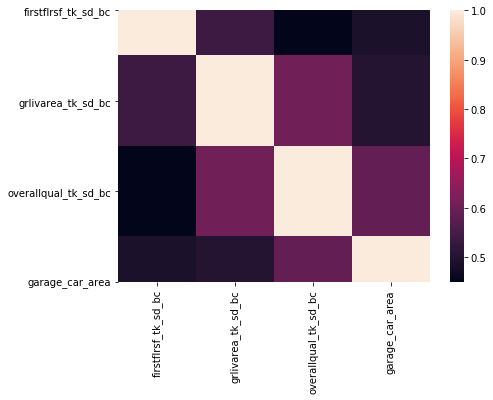

In [48]:
f, axes = plt.subplots(1, 1, figsize=(7, 5))
sns.heatmap(df_clean.loc[:, cont_corrected_features].corr(), ax=axes)
plt.show()

### Correlated categorical features
Look for correlated dummy features and remove them. I will use a cutoff of $\pm$0.8 in correlation.

In [49]:
dummy_features = [x for x in df_clean.columns.tolist() if x[-3:] == '_oh']
df_cat_correalated = df_clean.loc[:, dummy_features].corr().copy()

In [50]:
df_cat_correalated[df_cat_correalated < -0.8].dropna(how='all').dropna(how='all', axis=1)

,mszoning_RL_oh,mszoning_RM_oh,masvnrtype_BrkFace_oh,masvnrtype_None_oh,exterqual_Gd_oh,exterqual_TA_oh,extercond_Gd_oh,extercond_TA_oh,kitchenqual_Gd_oh,kitchenqual_TA_oh
mszoning_RL_oh,NaN,-0.808585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mszoning_RM_oh,-0.808585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
masvnrtype_BrkFace_oh,NaN,NaN,NaN,-0.806337,NaN,NaN,NaN,NaN,NaN,NaN
masvnrtype_None_oh,NaN,NaN,-0.806337,NaN,NaN,NaN,NaN,NaN,NaN,NaN
exterqual_Gd_oh,NaN,NaN,NaN,NaN,NaN,-0.906121,NaN,NaN,NaN,NaN
exterqual_TA_oh,NaN,NaN,NaN,NaN,-0.906121,NaN,NaN,NaN,NaN,NaN
extercond_Gd_oh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.894567,NaN,NaN
extercond_TA_oh,NaN,NaN,NaN,NaN,NaN,NaN,-0.894567,NaN,NaN,NaN
kitchenqual_Gd_oh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.824457
kitchenqual_TA_oh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.824457,NaN


In [51]:
df_positive_corr_cats = df_cat_correalated[df_cat_correalated < -0.8].dropna(how='all').dropna(how='all',
                                                                                               axis=1).copy()

In [52]:
df_cat_correalated[(df_cat_correalated > 0.8) & (df_cat_correalated < 1.0)].dropna(how='all').dropna(how='all', axis=1)

,mszoning_FV_oh,neighborhood_Somerst_oh,foundation_Slab_oh,bsmtqual_None_oh,bsmtcond_None_oh,bsmtexposure_None_oh,saletype_New_oh,salecondition_Partial_oh
mszoning_FV_oh,NaN,0.862807,NaN,NaN,NaN,NaN,NaN,NaN
neighborhood_Somerst_oh,0.862807,NaN,NaN,NaN,NaN,NaN,NaN,NaN
foundation_Slab_oh,NaN,NaN,NaN,0.801733,0.801733,NaN,NaN,NaN
bsmtqual_None_oh,NaN,NaN,0.801733,NaN,NaN,0.986408,NaN,NaN
bsmtcond_None_oh,NaN,NaN,0.801733,NaN,NaN,0.986408,NaN,NaN
bsmtexposure_None_oh,NaN,NaN,NaN,0.986408,0.986408,NaN,NaN,NaN
saletype_New_oh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.986819
salecondition_Partial_oh,NaN,NaN,NaN,NaN,NaN,NaN,0.986819,NaN


In [53]:
df_negative_corr_cats = df_cat_correalated[(df_cat_correalated > 0.8) & 
                                       (df_cat_correalated < 1.0)].dropna(how='all').dropna(how='all', 
                                                                                            axis=1).copy()

In [54]:
# Gather the positively correlated features and the negatively correlated features
correlated_cats = df_positive_corr_cats.columns.tolist() + df_negative_corr_cats.columns.tolist()

# Remove the correlated features from the list of dummy features
dummy_features = [x for x in dummy_features if x not in correlated_cats]

## Modeling
Now that I have selected the best features, I can begin the modeling process.

### Model 1
In my first model, I will create an ordinary linear regression model using Scikit-Learn.

In [55]:
all_features = dummy_features + cont_corrected_features
df_model_1 = df_clean.loc[:, all_features + ['saleprice_tk_sd_bc']].copy()

In [56]:
X = df_model_1.loc[:, all_features]
y = df_model_1['saleprice_tk_sd_bc']

In [57]:
hp.run_linear_model(LinearRegression, X, y, print_results=True)

Prediction Metrics:
* R-squared: 0.871
* MAE = 0.070
* MSE = 0.010
* RMSE = 0.098
* MAPE = 9.957%


In [58]:
hp.compare_scores()

Comparing Scores:
 * train: 0.885
 * test: 0.871


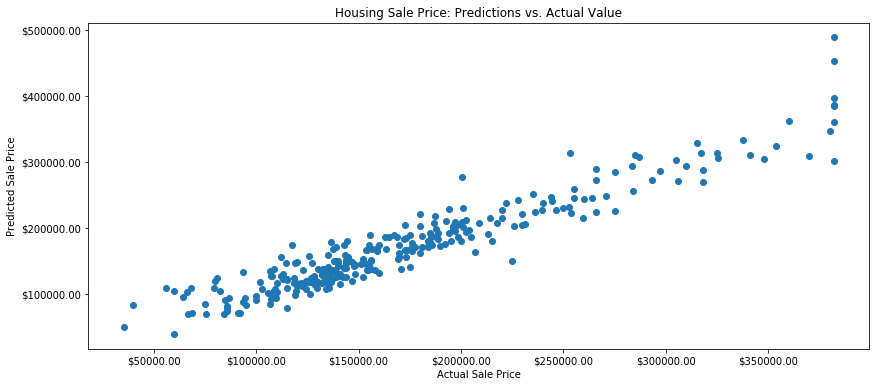

In [59]:
hp.plot_predictions(df_clean, 'saleprice_tk_sd_bc')

**Observations:** The high train and test scores indicate that this model is performing well already.

### Model 2
Using the results from Model 1, I will select only those features with an F-statistic p-value less than 0.05. These are the features that contribute most to the model. I will then rerun the model and see if the prediction metrics improve.

In [60]:
df_ftest = hp.ftest_feature_selection()

In [61]:
df_ftest.sort_values(by='pval')

,feature,F,pval,coeffs
77,overallqual_tk_sd_bc,2206.402797,3.605700e-271,0.091874
76,grlivarea_tk_sd_bc,1294.758881,2.509549e-191,0.252556
78,garage_car_area,947.789232,8.251086e-153,0.004453
75,firstflrsf_tk_sd_bc,643.723175,1.948300e-113,0.071251
58,fireplacequ_None_oh,437.508156,9.512959e-83,-0.062335
37,foundation_PConc_oh,413.279827,6.952948e-79,0.039241
42,bsmtqual_TA_oh,336.450606,3.183423e-66,-0.037035
63,garagefinish_Unf_oh,273.363912,2.508592e-55,-0.033977
41,bsmtqual_Gd_oh,175.457670,2.068440e-37,-0.024515
54,centralair_Y_oh,173.758186,4.349410e-37,0.088434


In [62]:
print(f'The number of features will now be reduced from {len(all_features)} to {len(df_ftest)}.')

The number of features will now be reduced from 79 to 58.


In [63]:
important_model_features = df_ftest['feature'].tolist()
df_model_2 = df_clean.loc[:, important_model_features + ['saleprice_tk_sd_bc']].copy()

In [64]:
X = df_model_2.loc[:, important_model_features]
y = df_model_2['saleprice_tk_sd_bc']

In [65]:
hp.run_linear_model(LinearRegression, X, y, print_results=True)

Prediction Metrics:
* R-squared: 0.880
* MAE = 0.069
* MSE = 0.009
* RMSE = 0.094
* MAPE = 9.069%


In [66]:
hp.compare_scores()

Comparing Scores:
 * train: 0.881
 * test: 0.880


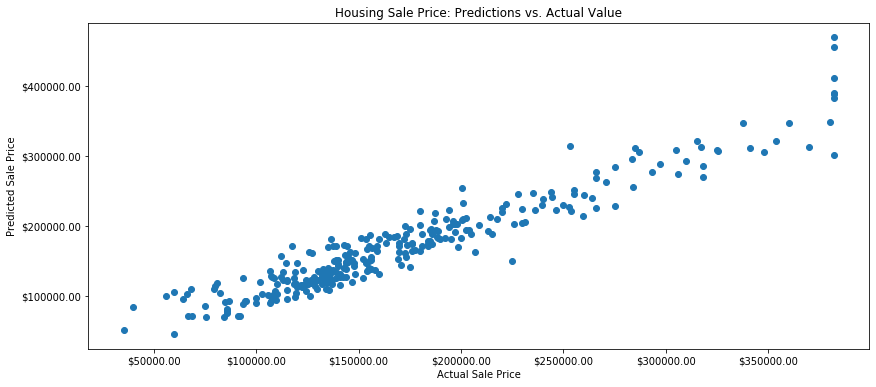

In [67]:
hp.plot_predictions(df_clean, 'saleprice_tk_sd_bc')

**Observations:** The test accuracy has increased to 0.880, indicating the removing the irrelavent features had a positive affect.

In the next few models I will try regularization techniques and explore if this will improve the model performance. For each technique, I will use a grid search method to find the best hyperparameters to use for the regularization.

### Model 3: Ridge Regularization

In [68]:
alpha_list = [2**x for x in list(range(10))]
df_grid = hp.grid_search(Ridge, X, y, alpha_list, num_folds=10)

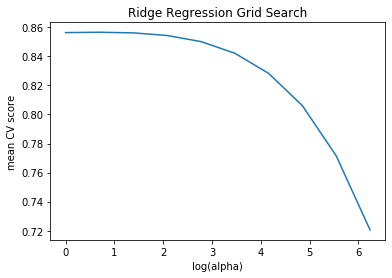

In [69]:
plt.plot(np.log(df_grid['alpha']), df_grid['mean_cv_score'])
plt.title('Ridge Regression Grid Search')
plt.xlabel('log(alpha)')
plt.ylabel('mean CV score')
plt.show()

In [70]:
df_grid.sort_values(by='mean_cv_score', ascending=False)

,alpha,mean_cv_score
1,2,0.856644
0,1,0.856403
2,4,0.856212
3,8,0.854397
4,16,0.850217
5,32,0.842205
6,64,0.828339
7,128,0.806061
8,256,0.771529
9,512,0.720515


**Observations:** The best hypeparameter for Ridge regularization is an alpha = 2.

In [71]:
hp.run_linear_model(Ridge, X, y, alpha=2, print_results=True)

Prediction Metrics:
* R-squared: 0.883
* MAE = 0.068
* MSE = 0.009
* RMSE = 0.093
* MAPE = 8.715%


In [72]:
hp.compare_scores()

Comparing Scores:
 * train: 0.880
 * test: 0.883


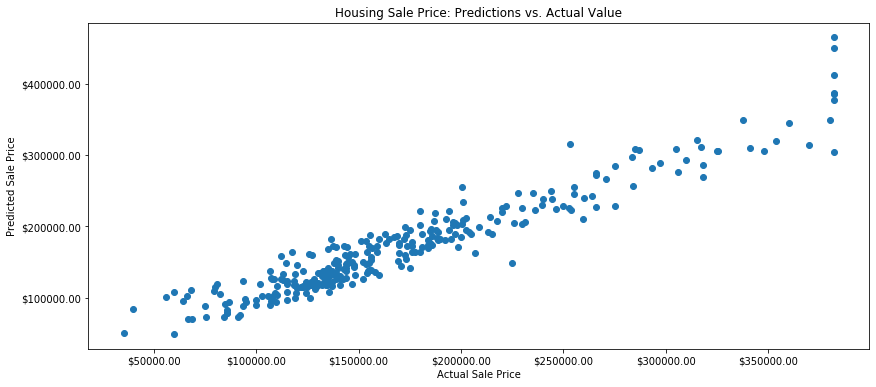

In [73]:
hp.plot_predictions(df_clean, 'saleprice_tk_sd_bc')

**Observations:** The test accuracy has increased from 0.880 to 0.883, indicating the Ridge regularization helped the model perform better.

### Model 4: Lasso Regularization

In [74]:
alpha_list = [0.5*(10**(-1*x)) for x in list(range(7))]
df_grid = hp.grid_search(Lasso, X, y, alpha_list, num_folds=10)

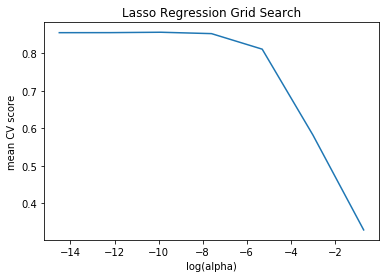

In [75]:
plt.plot(np.log(df_grid['alpha']), df_grid['mean_cv_score'])
plt.title('Lasso Regression Grid Search')
plt.xlabel('log(alpha)')
plt.ylabel('mean CV score')
plt.show()

In [76]:
df_grid.sort_values(by='mean_cv_score', ascending=False)

,alpha,mean_cv_score
4,5.000000e-05,0.856128
5,5.000000e-06,0.855090
6,5.000000e-07,0.854970
3,5.000000e-04,0.852448
2,5.000000e-03,0.811048
1,5.000000e-02,0.582187
0,5.000000e-01,0.329377


**Observations:** The best alpha for Lasso regularization is 5e-5.

In [77]:
hp.run_linear_model(Lasso, X, y, alpha=5e-5, print_results=True)

Prediction Metrics:
* R-squared: 0.881
* MAE = 0.068
* MSE = 0.009
* RMSE = 0.094
* MAPE = 8.982%


In [78]:
hp.compare_scores()

Comparing Scores:
 * train: 0.881
 * test: 0.881


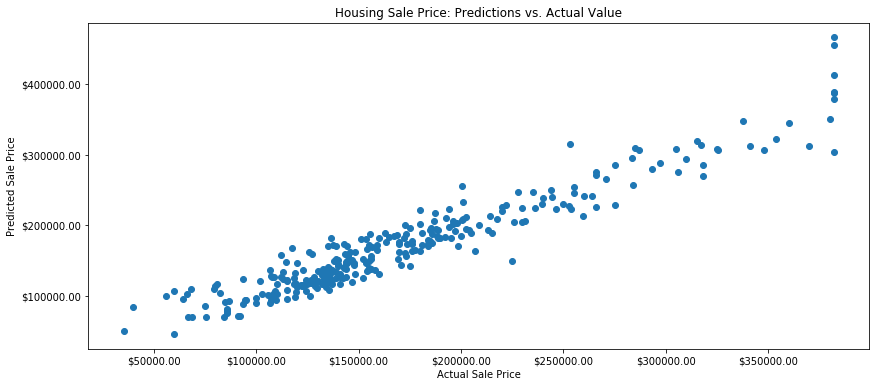

In [79]:
hp.plot_predictions(df_clean, 'saleprice_tk_sd_bc')

**Observations:** Lasso regularization did not perform as well as Ridge. The test score reduced to 0.881.

### Model 5: Elastic Net Regularization

In [80]:
alpha_list = [0.5*(10**(-1*x)) for x in list(range(5))]
l1_ratio_list = [0.5*(10**(-1*x)) for x in list(range(5))]
df_grid = hp.grid_search(ElasticNet, X, y, alpha_list, l1_ratio_list=l1_ratio_list, num_folds=10)

In [81]:
# Combine alpha and l1_ratio so that I can plot them versus the mean CV score
df_grid['alpha_l1_ratio'] = df_grid['alpha'] + df_grid['l1_ratio']
df_grid = df_grid.sort_values(by='alpha_l1_ratio').copy()

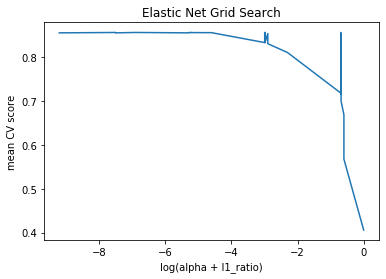

In [82]:
plt.plot(np.log(df_grid['alpha_l1_ratio']), df_grid['mean_cv_score'])
plt.title('Elastic Net Grid Search')
plt.xlabel('log(alpha + l1_ratio)')
plt.ylabel('mean CV score')
plt.show()

In [83]:
df_grid.sort_values(by='mean_cv_score', ascending=False).head()

,alpha,mean_cv_score,l1_ratio,alpha_l1_ratio
16,0.0005,0.856303,0.05000,0.05050
17,0.0005,0.856030,0.00500,0.00550
18,0.0005,0.856000,0.00050,0.00100
15,0.0005,0.855999,0.50000,0.50050
19,0.0005,0.855997,0.00005,0.00055


**Observations:** The best combination of hyperparameters for Elastic Net regularization is an alpha = 0.0005 and an L1 ratio = 0.05.

In [84]:
hp.run_linear_model(ElasticNet, X, y, alpha=5e-4, l1_ratio=5e-2, print_results=True)

Prediction Metrics:
* R-squared: 0.882
* MAE = 0.068
* MSE = 0.009
* RMSE = 0.093
* MAPE = 8.900%


In [85]:
hp.compare_scores()

Comparing Scores:
 * train: 0.881
 * test: 0.882


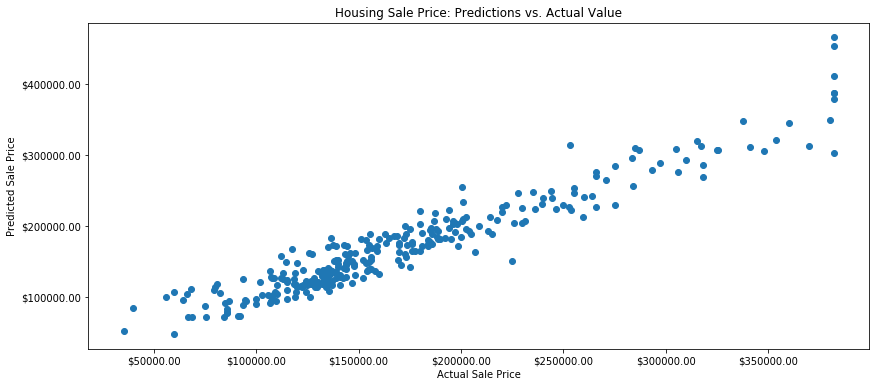

In [86]:
hp.plot_predictions(df_clean, 'saleprice_tk_sd_bc')

**Observations:** Elastic Net regularization did not peform better than Ridge. Ridge regularization remain the best regulariation method as well as the best model so far.

### Model 6
Now, I will add information from a climate dataset taken from the [NOAA](https://www.ncdc.noaa.gov/data-access/quick-links#loc-clim). Specifically, I will consider average yearly temperatures for Story County, where Ames is located, during the period when the houses in the housing dataset were sold, which is 2006 - 2010.

In [87]:
df_climate = pd.read_csv('./data/story_county_weather.csv', encoding='latin')

/Users/dave/anaconda3/envs/py_36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (3,19,25,26,27,28,29,35,36,41,42,49,51,55,56,59,60,62,63,95,111,113,114,117,118,119) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [88]:
print(f'The climate dataset has {len(df_climate.columns)} columns.')

The climate dataset has 124 columns.


I am only interested in the _MonthlyMeanTemperature_ and _DATE_ column.

In [89]:
df_climate.loc[:, ['DATE', 'MonthlyMeanTemperature']].describe().T

,count,mean,std,min,25%,50%,75%,max
MonthlyMeanTemperature,57.0,48.880702,20.253117,13.9,33.0,53.7,68.6,75.5


Gather the data from the two columns I am interested in into a single `DataFrame`.

In [90]:
df_temperatures = df_climate.loc[:, ['DATE', 'MonthlyMeanTemperature']].copy()
df_temperatures.dropna(inplace=True)
df_temperatures['DATE'] = pd.to_datetime(df_temperatures['DATE'])
df_temperatures.set_index(['DATE'], inplace=True)

Resample the `DataFrame` by year to find the average yearly temperature.

In [91]:
df_yearly_temps = df_temperatures.resample('Y').mean()
df_yearly_temps.index = df_yearly_temps.index.year

In [92]:
df_yearly_temps

,MonthlyMeanTemperature
DATE,
2006,50.716667
2007,48.725000
2008,49.440000
2009,46.981818
2010,48.475000


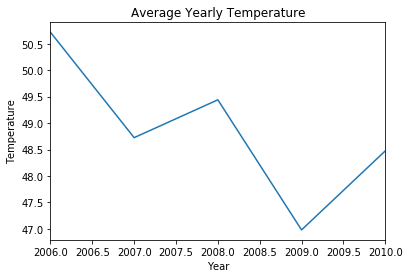

In [93]:
df_yearly_temps.loc[:, 'MonthlyMeanTemperature'].plot()
plt.title('Average Yearly Temperature')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.show()

Standardize the temperatures so that they are on the same scale as the rest of the features in the dataset I have been using for modeling.

In [94]:
mean_temp = df_yearly_temps['MonthlyMeanTemperature'].mean()
std_temp = df_yearly_temps['MonthlyMeanTemperature'].std()
df_yearly_temps['standard_temps'] = (df_yearly_temps['MonthlyMeanTemperature'] - mean_temp) / std_temp

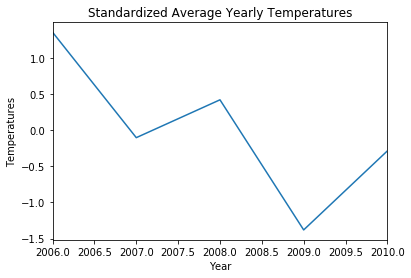

In [95]:
df_yearly_temps.loc[:, 'standard_temps'].plot()
plt.title('Standardized Average Yearly Temperatures')
plt.xlabel('Year')
plt.ylabel('Temperatures')
plt.show()

Create the `DataFrame` for model 6. Include the _id_ column so that I can use it to find the year the house was sold, which I will in turn use to associate with the average temperature for that year.

In [96]:
df_model_6 = df_clean.loc[:, important_model_features + ['saleprice_tk_sd_bc', 'id']].copy()

In [97]:
print(f"The years sold are: {df_clean['yrsold'].sort_values().unique().tolist()}")

The years sold are: [2006, 2007, 2008, 2009, 2010]


In [98]:
average_temperatures = []
for id in df_model_6['id']:
    year = df_clean.loc[df_clean['id'] == id, 'yrsold'].values[0]
    average_temperatures.append(df_yearly_temps.loc[year, 'standard_temps'])
df_model_6['avgyrtemp_sd'] = average_temperatures

In [99]:
X = df_model_6.loc[:, important_model_features + ['avgyrtemp_sd']]
y = df_model_6['saleprice_tk_sd_bc']

In [100]:
hp.run_linear_model(LinearRegression, X, y, print_results=True)

Prediction Metrics:
* R-squared: 0.880
* MAE = 0.069
* MSE = 0.009
* RMSE = 0.094
* MAPE = 9.044%


In [101]:
hp.compare_scores()

Comparing Scores:
 * train: 0.881
 * test: 0.880


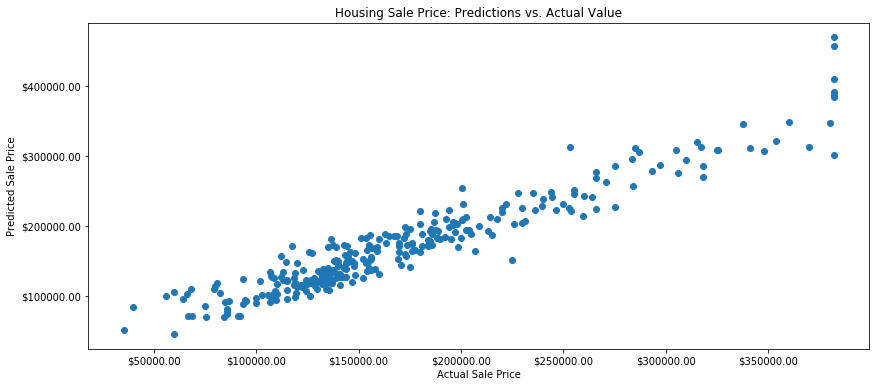

In [102]:
hp.plot_predictions(df_clean, 'saleprice_tk_sd_bc')

### Model 7
Now, include Ridge regression with the dataset used for model 6.

In [103]:
alpha_list = [2**x for x in list(range(10))]
df_grid = hp.grid_search(Ridge, X, y, alpha_list, num_folds=10)

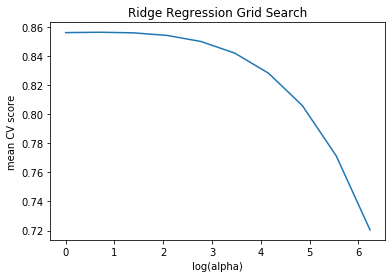

In [104]:
plt.plot(np.log(df_grid['alpha']), df_grid['mean_cv_score'])
plt.title('Ridge Regression Grid Search')
plt.xlabel('log(alpha)')
plt.ylabel('mean CV score')
plt.show()

In [105]:
df_grid.sort_values(by='mean_cv_score', ascending=False).head()

,alpha,mean_cv_score
1,2,0.856500
0,1,0.856238
2,4,0.856095
3,8,0.854303
4,16,0.850139


**Observations:** The best alpha for Ridge regularization is 2.

In [106]:
hp.run_linear_model(Ridge, X, y, alpha=2, print_results=True)

Prediction Metrics:
* R-squared: 0.883
* MAE = 0.068
* MSE = 0.009
* RMSE = 0.093
* MAPE = 8.695%


In [107]:
hp.compare_scores()

Comparing Scores:
 * train: 0.880
 * test: 0.883


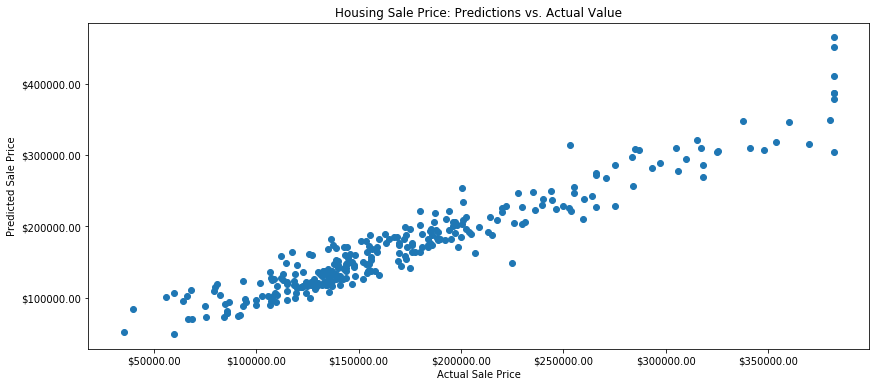

In [108]:
hp.plot_predictions(df_clean, 'saleprice_tk_sd_bc')

#### Model Evaluation

Let's assess the importance of this new feature in the model.

In [109]:
dict_test = hp.model_stats_dict['train_stats']
del dict_test['r-squared']

In [110]:
df_test = pd.DataFrame(dict_test)

In [111]:
df_test.sort_values(by='pval', ascending=False).head()

,features,coeffs,F-stat,pval
58,avgyrtemp_sd,0.001926,0.396510,0.529021
37,bsmtexposure_Mn_oh,0.004494,4.085328,0.043485
27,extercond_Po_oh,-0.072816,4.166027,0.041467
46,fireplacequ_Po_oh,-0.064511,4.359515,0.037019
15,neighborhood_NWAmes_oh,-0.017614,4.729757,0.029846


The high p-value and very small coefficient indicates that this feature is very useless for the model.

## Conclusions

In this project, I created several models to predict housing prices in Ames, Iowa. I determined that the most important features in predicting housing price are the overall quality of the property, the above ground living area, and the garage/car area. 

I added average yearly temperatures as an additional feature with the thinking that people might be more/less inclined to buy houses depending on the temperature. I determined that average yearly temperature did not have a strong predictive quality and thus is not necessary to include in the model.

The best model was Model 3, which produced a test R<sup>2</sup> score of 0.883. In all cases, the training score and test score were close, indicating that no model suffered from overfitting.